In [1]:
import h5py

In [2]:
data_bg = h5py.File('../data/SimpleQCD.h5', 'r')
data_sig = h5py.File('../data/SimpleVBF.h5', 'r')

In [3]:
import numpy as np

def create_single_event_data(event_info, n_particles):
    result = np.empty((0), dtype=np.float32)
    for i in range(n_particles):
        particle_info = np.asarray(list(event_info[i]))
        result = np.concatenate((result, particle_info), axis=0)

    return result

def create_data(events, n_particles, is_background):
    result = np.empty((0, n_particles * 7), dtype=np.float32)
    labels = np.empty((0, 1), dtype=np.float32)
    for event_number in range(len(events)):
        event_data = create_single_event_data(events[event_number], n_particles)
        result = np.concatenate((result, [event_data]), axis=0)
        labels = np.concatenate((labels, [[0.0 if is_background else 1.0]]), axis=0)

    return result, labels



In [4]:
input_bg, labels_bg = create_data(data_bg["INPUTS"]["PARTICLES"],5, is_background=True)
input_sig, labels_sig = create_data(data_sig["INPUTS"]["PARTICLES"],5, is_background=False)
input_data = np.concatenate((input_bg, input_sig), axis=0)
labels = np.concatenate((labels_bg, labels_sig), axis=0)

In [5]:
import torch
device = "mps" if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")
input_data.shape

Using mps device


(148031, 35)

In [6]:
# Scale the data to lie between -1 and 1 using sklearn StandardScaler
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(input_data)

In [7]:
# As tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32, device=device)
y_train_tensor = torch.tensor(labels, dtype=torch.float32, device=device)

In [23]:
from torch.utils.data import TensorDataset, DataLoader

# dataset = TensorDataset(sub_inputs, sub_target)
dataset = TensorDataset(X_train_tensor, y_train_tensor)
dataloader = DataLoader(dataset, batch_size=10000, shuffle=True, drop_last=True)

In [24]:
import torch.nn as nn
import torch.nn.functional as F

class BasicTransformer(nn.Module):
    def __init__(self, input_dim, nhead, num_layers):
        super(BasicTransformer, self).__init__()
        # Input embedding head
        self.input_embedder = nn.Sequential(
            nn.Linear(input_dim, input_dim),
            nn.ReLU(),
            nn.Linear(input_dim, 32),
        )
        # Transformer Encoder
        self.transformer_encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=32, nhead=2,batch_first=True),
            num_layers=num_layers, enable_nested_tensor=False)


        self.output_classifier_head = nn.Sequential(
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1),
        )

    def mean_pooling(self,x):
        """
        Mean pooling implementation
        """
        # x: (batch_size, num_tokens, embed_dim)
        return x.mean(dim=1)

    def attention_pooling(self,x):

        """
        Attention pooling implementation
        """
        # x: (batch_size, num_tokens, embed_dim)
        B = x.size(0)
        pool_query = nn.Parameter(torch.randn(1, 1, 32)).to(device)
        query = pool_query.expand(B, -1, -1)  # (B, 1, embed_dim)

        # Compute attention scores
        attn_scores = torch.matmul(query, x.transpose(1, 2))  # (B, 1, num_tokens)
        attn_weights = torch.softmax(attn_scores, dim=-1)     # (B, 1, num_tokens)

        # Weighted sum
        pooled = torch.matmul(attn_weights, x)  # (B, 1, embed_dim)
        return pooled.squeeze(1)

    def forward(self, x):
        x = self.input_embedder(x)
        x = self.transformer_encoder(x)
        # x = self.attention_pooling(x)
        # x = self.mean_pooling(x)
        x = self.output_classifier_head(x)
        return torch.sigmoid(x)

In [25]:
model = BasicTransformer(input_dim=35, nhead=1, num_layers=2)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.002, weight_decay=0.0001)
criterion = nn.BCELoss(reduction='mean')

In [26]:
num_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {num_params:,}")
param_size_MB = num_params * 4 / 1024  # Approximate size in MB (assuming 4 bytes per parameter)
print(f"Approx model size: {param_size_MB:.2f} MB")

Total parameters: 277,965
Approx model size: 1085.80 MB


In [27]:
# Training loop with losses stored  in a list
train_losses = []
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, targets in dataloader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    avg_loss = running_loss / len(dataloader)
    train_losses.append(avg_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")

Epoch 1/20, Loss: 0.6844
Epoch 2/20, Loss: 0.6770
Epoch 3/20, Loss: 0.6770
Epoch 4/20, Loss: 0.6769
Epoch 5/20, Loss: 0.6771
Epoch 6/20, Loss: 0.6770
Epoch 7/20, Loss: 0.6769
Epoch 8/20, Loss: 0.6769
Epoch 9/20, Loss: 0.6768
Epoch 10/20, Loss: 0.6767
Epoch 11/20, Loss: 0.6768
Epoch 12/20, Loss: 0.6768
Epoch 13/20, Loss: 0.6767
Epoch 14/20, Loss: 0.6770
Epoch 15/20, Loss: 0.6769
Epoch 16/20, Loss: 0.6770
Epoch 17/20, Loss: 0.6769
Epoch 18/20, Loss: 0.6770
Epoch 19/20, Loss: 0.6771
Epoch 20/20, Loss: 0.6767


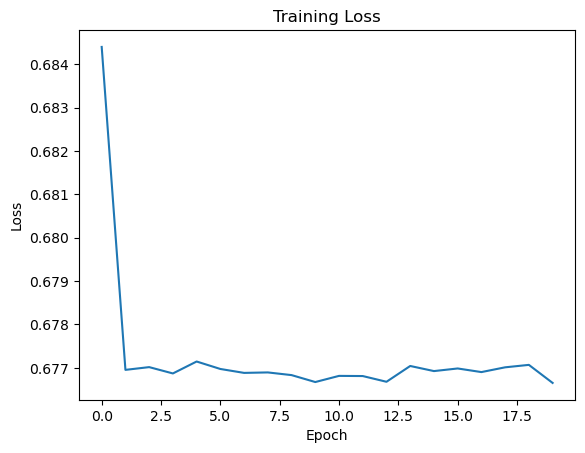

In [28]:
import matplotlib.pyplot as plt
plt.plot(train_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()